In [1]:
import os
import re
import numpy as np
import torch
import torch.distributions as tdst
import scipy
from scipy.spatial.distance import pdist, squareform
from scipy.stats import multivariate_normal
from scipy.stats import qmc
import numpy.matlib as nm

from mxmc import Optimizer

from rich.progress import track

/Users/ajivani/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 150
plt.style.use('seaborn-v0_8-notebook')
plt.rc("font", family="serif")
plt.rc("axes.spines", top=True, right=True)
# set explicit fontsizes for ticks, lables, legend and title
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=14, edgecolor="none", frameon=True)
plt.rc('figure', titlesize=16)

# add faint gridlines to rc settings (change grid alpha and grid linestyle )
# set grid to always be on
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '--'


marker_symbol = u'\u2B2C'

In [3]:
# mu_oracle_hf = np.array([0.6, 0.1])
# cov_oracle_hf = np.array([[2.0, 0.4], [0.4, 0.5]])

# mu_oracle_lf1 = np.array([0.8, 0.32])
# cov_oracle_lf1 = np.array([[1.5, 0.35], [0.35, 0.5]])

mu_oracle_hf = np.array([0.5, 0.2])
cov_oracle_hf = np.array([[2.0, 0.3], [0.3, 0.5]])

mu_oracle_lf1 = np.array([-2.5, -1.5])
cov_oracle_lf1 = np.array([[1.5, 0.0], [0.0, 0.5]])

In [4]:
def autodiff_log_prob(log_prob_fn):
    """
    Wraps a log probability function to return both the (log_prob, grad_log_prob).
    log_prob_fn: Return the log probability for a tensor input.
    """
    def wrapped(theta):
        theta =  torch.as_tensor(theta, dtype=torch.float32).clone().detach().requires_grad_(True)
        log_prob = log_prob_fn(theta)
        grad_log_prob = torch.autograd.grad(log_prob.sum(), theta)[0]
        return grad_log_prob.detach().numpy()
    
    return wrapped

In [5]:
def mvn_dlnprob_hf(theta, mu, cov):
    return -1*np.matmul(theta-nm.repmat(mu, theta.shape[0], 1),
                        np.linalg.inv(cov))

def mvn_dlnprob_lf(theta, mu, cov):
    return -1*np.matmul(theta-nm.repmat(mu, theta.shape[0], 1),
                        np.linalg.inv(cov))

In [6]:
def lnprob0_gaussian(theta):
    dist_gaussian = tdst.MultivariateNormal(torch.from_numpy(mu_oracle_hf), 
                                            torch.from_numpy(cov_oracle_hf)
                                           )
    
    return dist_gaussian.log_prob(theta)

def lnprob1_gaussian(theta):
    dist_gaussian = tdst.MultivariateNormal(torch.from_numpy(mu_oracle_lf1), 
                                            torch.from_numpy(cov_oracle_lf1)
                                           )
    
    return dist_gaussian.log_prob(theta)

In [7]:
class SVGD():
    """
    Adapted from DartML implementation with minor changes.
    """
    def __init__(self):
        pass

    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy, h)
    
    
    def update(self, x0, lnprob,
               n_iter = 1000,
               stepsize = 1e-3,
               bandwidth = -1,
               alpha = 0.9,
               return_all = False,
               debug = False):
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')

        theta_all = np.zeros((x0.shape[0], x0.shape[1], n_iter + 1))
        lengthscales_all = np.zeros(n_iter)
        theta = np.copy(x0)

        theta_all[:, :, 0] = x0
        
        fudge_factor = 1e-6
        historical_grad = 0

        for itn in track(range(1, n_iter + 1), description="Running iterations for particle position updates..."):

            lnpgrad = lnprob(theta)

            # calculating the kernel matrix
            kxy, dxkxy, h = self.svgd_kernel(theta, h=-1)
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]

            lengthscales_all[itn - 1] = h

            # adagrad
            if itn == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            
            theta = theta + stepsize * adj_grad
            theta_all[:, :, itn] = theta

        return theta_all, lengthscales_all

In [8]:
class BifidelitySVGDSingleSet():
    """
    A single subset of particles takes both hifi and lofi evaluations.
    """
    def __init__(self):
        pass

    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy, h)
    
    
    def update(self, x0, lnprob_1, lnprob_0,
               n_correct_idx,
               n_iter = 1000,
               stepsize = 5e-3,
               bandwidth = -1,
               alpha = 0.9,
               return_all = False,
               debug = False):
        
        
        if x0 is None:
            raise ValueError('x0 or lnprob cannot be None!')

        theta_all = np.zeros((x0.shape[0], x0.shape[1], n_iter + 1))
        lengthscales_all = np.zeros(n_iter)
        theta_all[:, :, 0] = x0
        
        fudge_factor = 1e-6
        historical_grad = 0

        for itn in track(range(1, n_iter + 1), description="Running iterations for particle position updates..."):
            #             print('iter ' + str(itn))

            if itn !=0:
                theta_lf = theta_all[:, :, itn - 1]
                theta_hf = theta_all[n_correct_idx, :, itn - 1]
                
            lnpgrad_1 = lnprob_1(theta_lf)
            lnpgrad_0 = lnprob_0(theta_hf)
            
            kxy1, dxkxy1, h1 = self.svgd_kernel(theta_lf, h=-1)
            kxy0, dxkxy0, h0 = self.svgd_kernel(theta_hf, h=-1)
            
            
            grad_theta = (np.matmul(kxy1, lnpgrad_1) + dxkxy1) / x0.shape[0]
            lengthscales_all[itn - 1] = h1
            
            grad_theta_correction = np.matmul(kxy1[:, n_correct_idx], (lnpgrad_0 - lnpgrad_1[n_correct_idx, :])) / theta_hf.shape[0]
            grad_theta = grad_theta + grad_theta_correction

            # adagrad
            if itn == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            
            #             theta = theta + stepsize * adj_grad
            theta_all[:, :, itn] = theta_all[:, :, itn - 1] + stepsize * adj_grad

        return theta_all, lengthscales_all

In [17]:
n_correct = 200
N_PARTICLES = 512
torch.manual_seed(2025)

# initial_particles = torch.normal(0.0, 1.0, size=(N_PARTICLES, 2))
sampler = qmc.Sobol(d=2, scramble=False)
initial_particles = sampler.random(n=N_PARTICLES)

# # rescale initial points to lie within -1, 1
initial_particles = 2 * initial_particles - 1

n_correct_idx = np.random.choice(N_PARTICLES, n_correct)

lnprob_1 = autodiff_log_prob(lnprob1_gaussian)
lnprob_0 = autodiff_log_prob(lnprob0_gaussian)

**Case 1: A Single Subset of Particles is Corrected**

In [18]:
svgd_obj = BifidelitySVGDSingleSet()

theta_all, lengthscales_all = svgd_obj.update(initial_particles,
                                             lnprob_1,
                                             lnprob_0,
                                             n_correct_idx,
                                             n_iter=1000,
                                             stepsize=0.1
                                             )

Output()

In [19]:
svgd_hf = SVGD()
theta_hf, lengthscales_hf = svgd_hf.update(initial_particles,
                                             lnprob_0,
                                             n_iter=1000,
                                             stepsize=0.1
                                             )

svgd_lf = SVGD()
theta_lf, lengthscales_lf = svgd_lf.update(initial_particles,
                                             lnprob_1,
                                             n_iter=1000,
                                             stepsize=0.1
                                             )

Output()

Output()

In [12]:
theta_lf.shape

(512, 2, 1001)

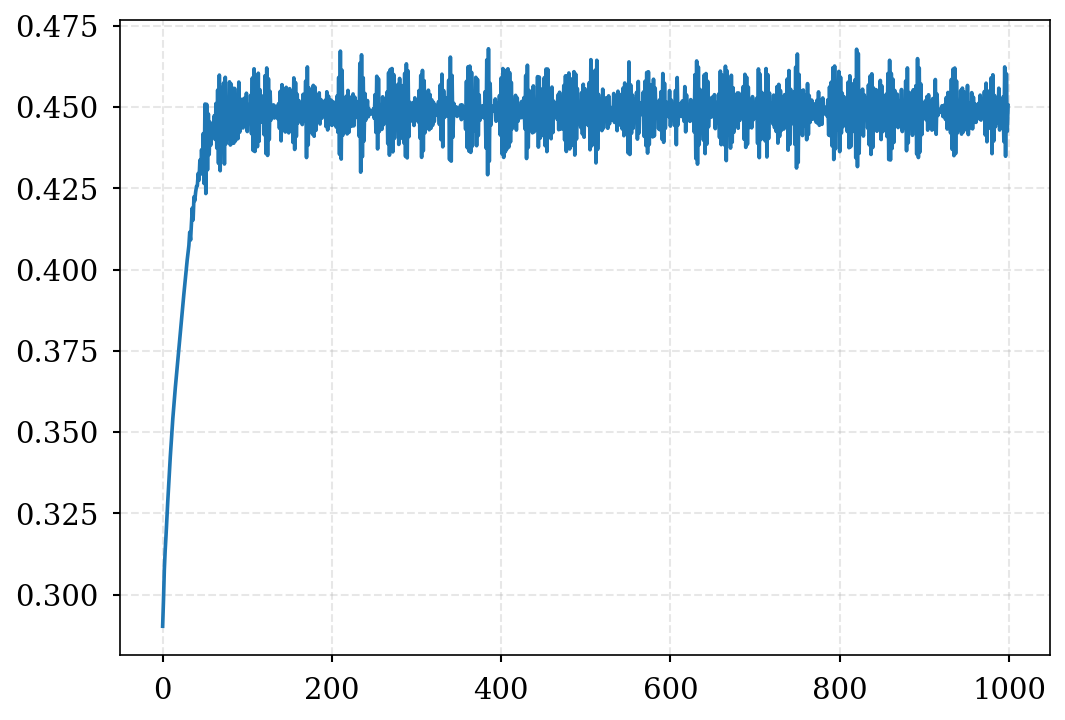

In [13]:
plt.plot(lengthscales_lf)

(-4.0, 4.0)

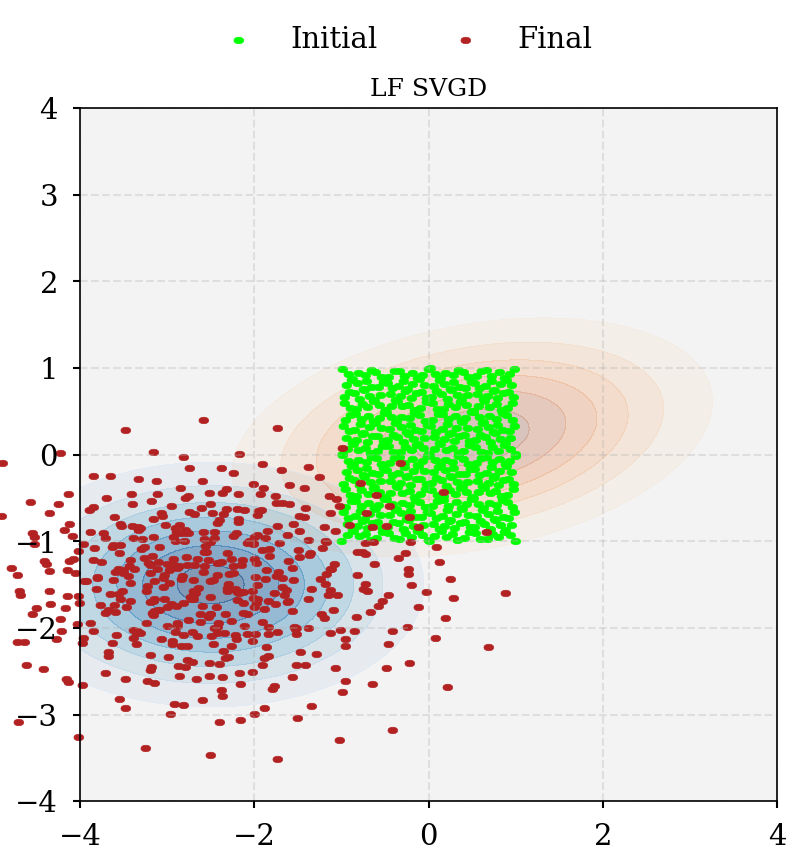

In [20]:
x, y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((x, y))

rv_hf = multivariate_normal(mu_oracle_hf, cov_oracle_hf)
rv_lf = multivariate_normal(mu_oracle_lf1, cov_oracle_lf1)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.contourf(x, y,
             rv_hf.pdf(pos),
             alpha=0.5,
             cmap='Oranges')

ax.contourf(x, y,
            rv_lf.pdf(pos),
            alpha=0.5,
            cmap='Blues')


# Scatter initial and final particles
ax.scatter(theta_lf[:, 0, 0], theta_lf[:, 1, 0],
            color="lime",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="Initial")


ax.scatter(theta_lf[:, 0, -1], theta_lf[:, 1, -1],
            color="firebrick",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="Final")

fig.legend(loc="upper center", ncol=2,)
ax.set_title("LF SVGD")
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)

(-4.0, 4.0)

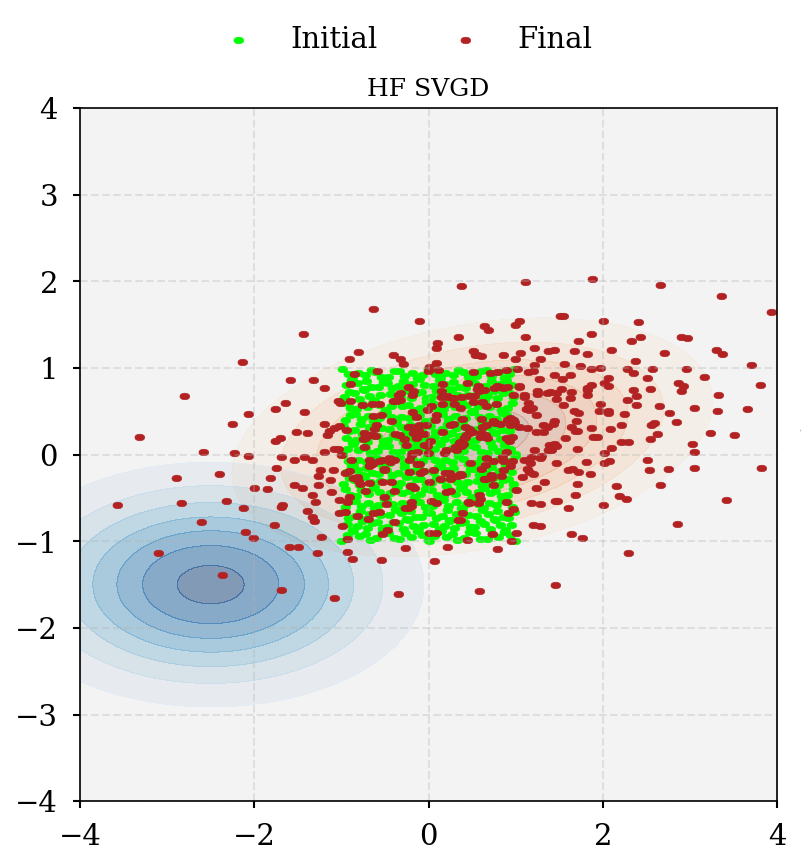

In [21]:
x, y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((x, y))

rv_hf = multivariate_normal(mu_oracle_hf, cov_oracle_hf)
rv_lf = multivariate_normal(mu_oracle_lf1, cov_oracle_lf1)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.contourf(x, y,
             rv_hf.pdf(pos),
             alpha=0.5,
             cmap='Oranges')

ax.contourf(x, y,
            rv_lf.pdf(pos),
            alpha=0.5,
            cmap='Blues')


# Scatter initial and final particles
ax.scatter(theta_hf[:, 0, 0], theta_hf[:, 1, 0],
            color="lime",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="Initial")


ax.scatter(theta_hf[:, 0, -1], theta_hf[:, 1, -1],
            color="firebrick",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="Final")

fig.legend(loc="upper center", ncol=2,)
ax.set_title("HF SVGD")
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)

(-4.0, 4.0)

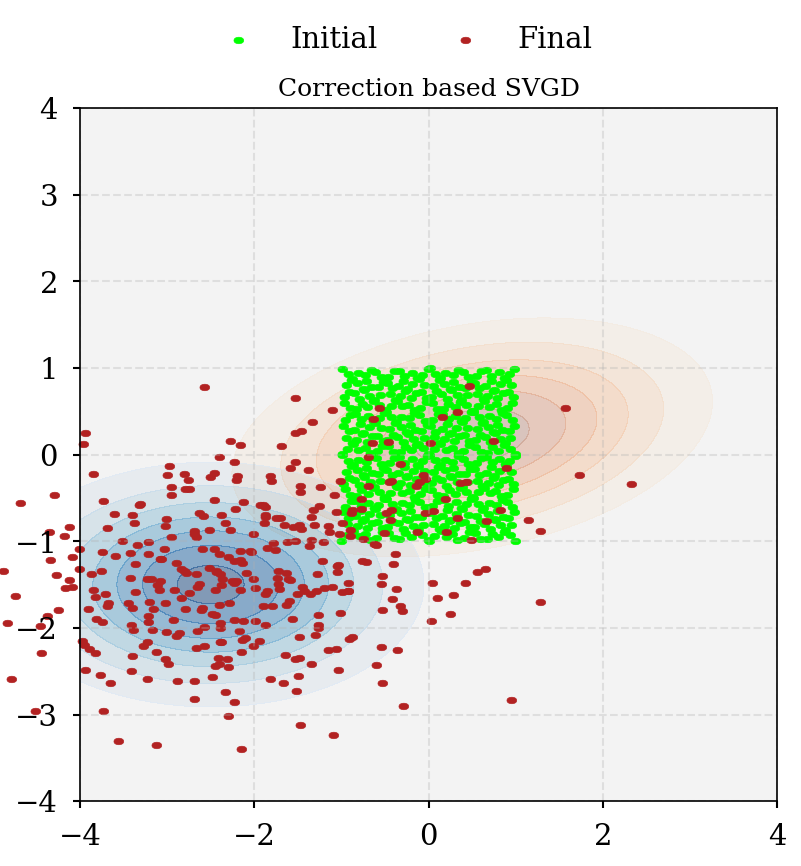

In [22]:
x, y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((x, y))

rv_hf = multivariate_normal(mu_oracle_hf, cov_oracle_hf)
rv_lf = multivariate_normal(mu_oracle_lf1, cov_oracle_lf1)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.contourf(x, y,
             rv_hf.pdf(pos),
             alpha=0.5,
             cmap='Oranges')

ax.contourf(x, y,
            rv_lf.pdf(pos),
            alpha=0.5,
            cmap='Blues')


# Scatter initial and final particles
ax.scatter(theta_all[:, 0, 0], theta_all[:, 1, 0],
            color="lime",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="Initial")


ax.scatter(theta_all[:, 0, -1], theta_all[:, 1, -1],
            color="firebrick",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="Final")


fig.legend(loc="upper center", ncol=2,)
ax.set_title("Correction based SVGD")
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)

In [23]:
# import gif
# from random import randint


# # (Optional) Set the dots per inch resolution to 300
# gif.options.matplotlib["dpi"] = 200

# # Decorate a plot function with @gif.frame
# @gif.frame
# def plot(i):
#     xi = x[i*10:(i+1)*10]
#     yi = y[i*10:(i+1)*10]
#     plt.scatter(xi, yi)
#     plt.xlim((0, 100))
#     plt.ylim((0, 100))

# # Construct "frames"
# frames = [plot(i) for i in range(10)]

# # Save "frames" to gif with a specified duration (milliseconds) between each frame
# gif.save(frames, 'example.gif', duration=50)

In [24]:
class BifidelitySVGDSingleSetHFCorr():
    """
    A single subset of particles takes both hifi and lofi evaluations. For this case, the hifi kernel is used to guide
    the correction and the correction is applied only to a specific subset of particles.
    """
    def __init__(self):
        pass

    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy, h)
    
    
    def update(self, x0, lnprob_1, lnprob_0,
               n_correct_idx,
               n_iter = 1000,
               stepsize = 5e-3,
               bandwidth = -1,
               alpha = 0.9,
               return_all = False,
               debug = False):
        
        
        if x0 is None:
            raise ValueError('x0 or lnprob cannot be None!')

        theta_all = np.zeros((x0.shape[0], x0.shape[1], n_iter + 1))
        lengthscales_all = np.zeros(n_iter)
        theta_all[:, :, 0] = x0
        
        fudge_factor = 1e-6
        historical_grad = 0

        for itn in track(range(1, n_iter + 1), description="Running iterations for particle position updates..."):
            #             print('iter ' + str(itn))

            if itn !=0:
                theta_lf = theta_all[:, :, itn - 1]
                theta_hf = theta_all[n_correct_idx, :, itn - 1]
                
            lnpgrad_1 = lnprob_1(theta_lf)
            lnpgrad_0 = lnprob_0(theta_hf)
            
            kxy1, dxkxy1, h1 = self.svgd_kernel(theta_lf, h=-1)
            kxy0, dxkxy0, h0 = self.svgd_kernel(theta_hf, h=-1)
            
            
            grad_theta = (np.matmul(kxy1, lnpgrad_1) + dxkxy1) / x0.shape[0]
            lengthscales_all[itn - 1] = h1
            
            grad_theta_correction = np.matmul(kxy0, (lnpgrad_0 - lnpgrad_1[n_correct_idx, :])) / theta_hf.shape[0]
            grad_theta[n_correct_idx, :] = grad_theta[n_correct_idx, :] + grad_theta_correction

            # adagrad
            if itn == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            
            #             theta = theta + stepsize * adj_grad
            theta_all[:, :, itn] = theta_all[:, :, itn - 1] + stepsize * adj_grad

        return theta_all, lengthscales_all

In [28]:
svgd_bifidelity_hf_corr = BifidelitySVGDSingleSetHFCorr()

theta_all_case12, lengthscales_all_case12 = svgd_bifidelity_hf_corr.update(initial_particles,
                                             lnprob_1,
                                             lnprob_0,
                                             n_correct_idx,
                                             n_iter=1000,
                                             stepsize=0.1
                                             )

Output()

(-4.0, 4.0)

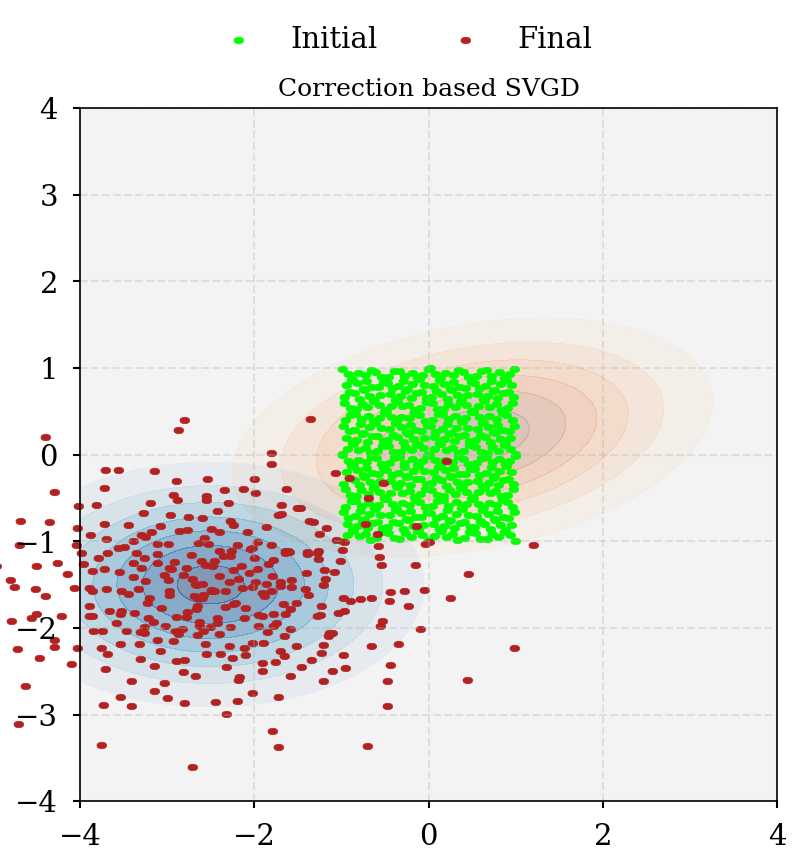

In [29]:
x, y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((x, y))

rv_hf = multivariate_normal(mu_oracle_hf, cov_oracle_hf)
rv_lf = multivariate_normal(mu_oracle_lf1, cov_oracle_lf1)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.contourf(x, y,
             rv_hf.pdf(pos),
             alpha=0.5,
             cmap='Oranges')

ax.contourf(x, y,
            rv_lf.pdf(pos),
            alpha=0.5,
            cmap='Blues')


# Scatter initial and final particles
ax.scatter(theta_all_case12[:, 0, 0], theta_all_case12[:, 1, 0],
            color="lime",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="Initial")


ax.scatter(theta_all_case12[:, 0, -1], theta_all_case12[:, 1, -1],
            color="firebrick",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="Final")


fig.legend(loc="upper center", ncol=2,)
ax.set_title("Correction based SVGD")
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)

**Case 2: Particles to be corrected are randomized for every SVGD iteration**

In [36]:
class BifidelitySVGDSingleSetRandomized():
    """
    A single subset of particles takes both hifi and lofi evaluations. Correction particles are randomized every iteration.
    """
    def __init__(self):
        pass

    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy, h)
    
    
    def update(self, x0, lnprob_1, lnprob_0,
               n_correct_idx_all,
               n_iter = 1000,
               stepsize = 5e-3,
               bandwidth = -1,
               alpha = 0.9,
               return_all = False,
               debug = False):
        
        
        if x0 is None:
            raise ValueError('x0 or lnprob cannot be None!')

        theta_all = np.zeros((x0.shape[0], x0.shape[1], n_iter + 1))
        lengthscales_all = np.zeros(n_iter)
        theta_all[:, :, 0] = x0
        
        fudge_factor = 1e-6
        historical_grad = 0

        for itn in track(range(1, n_iter + 1), description="Running iterations for particle position updates..."):
            #             print('iter ' + str(itn))

            if itn !=0:
                theta_lf = theta_all[:, :, itn - 1]
                theta_hf = theta_all[n_correct_idx_all[:, itn - 1], :, itn - 1]
                
            lnpgrad_1 = lnprob_1(theta_lf)
            lnpgrad_0 = lnprob_0(theta_hf)
            
            kxy1, dxkxy1, h1 = self.svgd_kernel(theta_lf, h=-1)
            kxy0, dxkxy0, h0 = self.svgd_kernel(theta_hf, h=-1)
            
            
            grad_theta = (np.matmul(kxy1, lnpgrad_1) + dxkxy1) / x0.shape[0]
            lengthscales_all[itn - 1] = h1
            
            grad_theta_correction = np.matmul(kxy1[:, n_correct_idx_all[:, itn - 1]], 
                                              (lnpgrad_0 - lnpgrad_1[n_correct_idx_all[:, itn - 1], :])) / theta_hf.shape[0]
            grad_theta = grad_theta + grad_theta_correction

            # adagrad
            if itn == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            
            #             theta = theta + stepsize * adj_grad
            theta_all[:, :, itn] = theta_all[:, :, itn - 1] + stepsize * adj_grad

        return theta_all, lengthscales_all

In [67]:
svgd_bifidelity_rd = BifidelitySVGDSingleSetRandomized()
n_correct_rd = 250
n_correct_idx_all = np.stack([np.random.choice(N_PARTICLES, n_correct_rd) for _ in range(1001)]).T

theta_all_rd, lengthscales_all_rd = svgd_bifidelity_rd.update(initial_particles,
                                             lnprob_1,
                                             lnprob_0,
                                             n_correct_idx_all,
                                             n_iter=1000,
                                             stepsize=0.1
                                             )

Output()

(-4.0, 4.0)

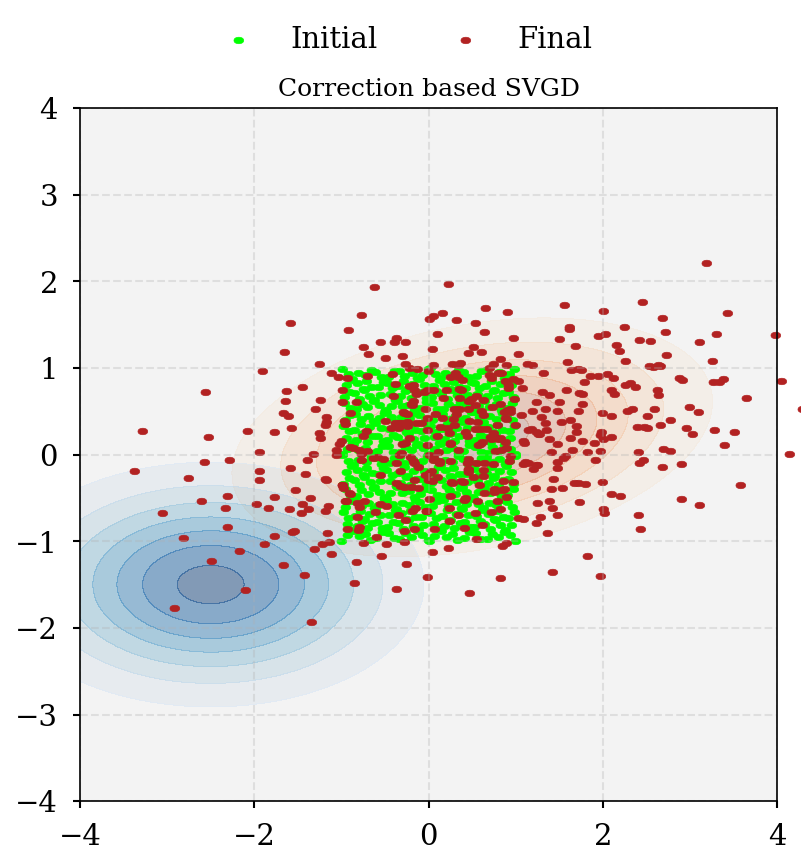

In [68]:
x, y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((x, y))

rv_hf = multivariate_normal(mu_oracle_hf, cov_oracle_hf)
rv_lf = multivariate_normal(mu_oracle_lf1, cov_oracle_lf1)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.contourf(x, y,
             rv_hf.pdf(pos),
             alpha=0.5,
             cmap='Oranges')

ax.contourf(x, y,
            rv_lf.pdf(pos),
            alpha=0.5,
            cmap='Blues')


# Scatter initial and final particles
ax.scatter(theta_all_rd[:, 0, 0], theta_all_rd[:, 1, 0],
            color="lime",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="Initial")


ax.scatter(theta_all_rd[:, 0, -1], theta_all_rd[:, 1, -1],
            color="firebrick",
            marker="$%s$" % marker_symbol,
            s=25,
            clip_on=False,
            label="Final")


fig.legend(loc="upper center", ncol=2,)
ax.set_title("Correction based SVGD")
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)

In [58]:
import gif
from random import randint
from matplotlib import pyplot as plt
gif.options.matplotlib["dpi"] = 200

@gif.frame
def plot_svgd_particle_contours(itn):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    ax.contourf(x, y,
                 rv_hf.pdf(pos),
                 alpha=0.5,
                 cmap='Oranges')

    ax.contourf(x, y,
                rv_lf.pdf(pos),
                alpha=0.5,
                cmap='Blues')

    ax.scatter(theta_all_rd[:, 0, itn], theta_all_rd[:, 1, itn],
                color="firebrick",
                marker="$%s$" % marker_symbol,
                s=25,
                clip_on=False,
                label="")
    
    ax.set_title("Itn {}".format(itn))


    ax.scatter(theta_all_rd[n_correct_idx_all[:, itn], 0, itn], theta_all_rd[n_correct_idx_all[:, itn], 1, itn],
                color="royalblue",
                marker="$%s$" % marker_symbol,
                s=25,
                clip_on=False,
                label="")
    
    ax.set_xlim((-4, 4))
    ax.set_ylim((-4, 4))

    
frames_all = [plot_svgd_particle_contours(i) for i in range(0, 1001, 20)]
gif.save(frames_all, 'svgd_randomized.gif', duration=0.5)

**Case 3: The budget follows a schedule. The number of particles corrected goes down gradually**.